In [9]:
!pip install monai scipy matplotlib torch torchvision Pillow

!pip install tqdm

!pip install h5py


  0%|          | 0/192 [00:00<?, ?it/s]/usr/local/python/3.12.1/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 192/192 [01:27<00:00,  2.19it/s]


Epoch 1/5, Loss: 102.2877


100%|██████████| 192/192 [01:22<00:00,  2.34it/s]


Epoch 2/5, Loss: 90.2530


100%|██████████| 192/192 [01:20<00:00,  2.40it/s]


Epoch 3/5, Loss: 83.4213


100%|██████████| 192/192 [01:20<00:00,  2.38it/s]


Epoch 4/5, Loss: 77.6507


100%|██████████| 192/192 [01:20<00:00,  2.38it/s]


Epoch 5/5, Loss: 72.4991


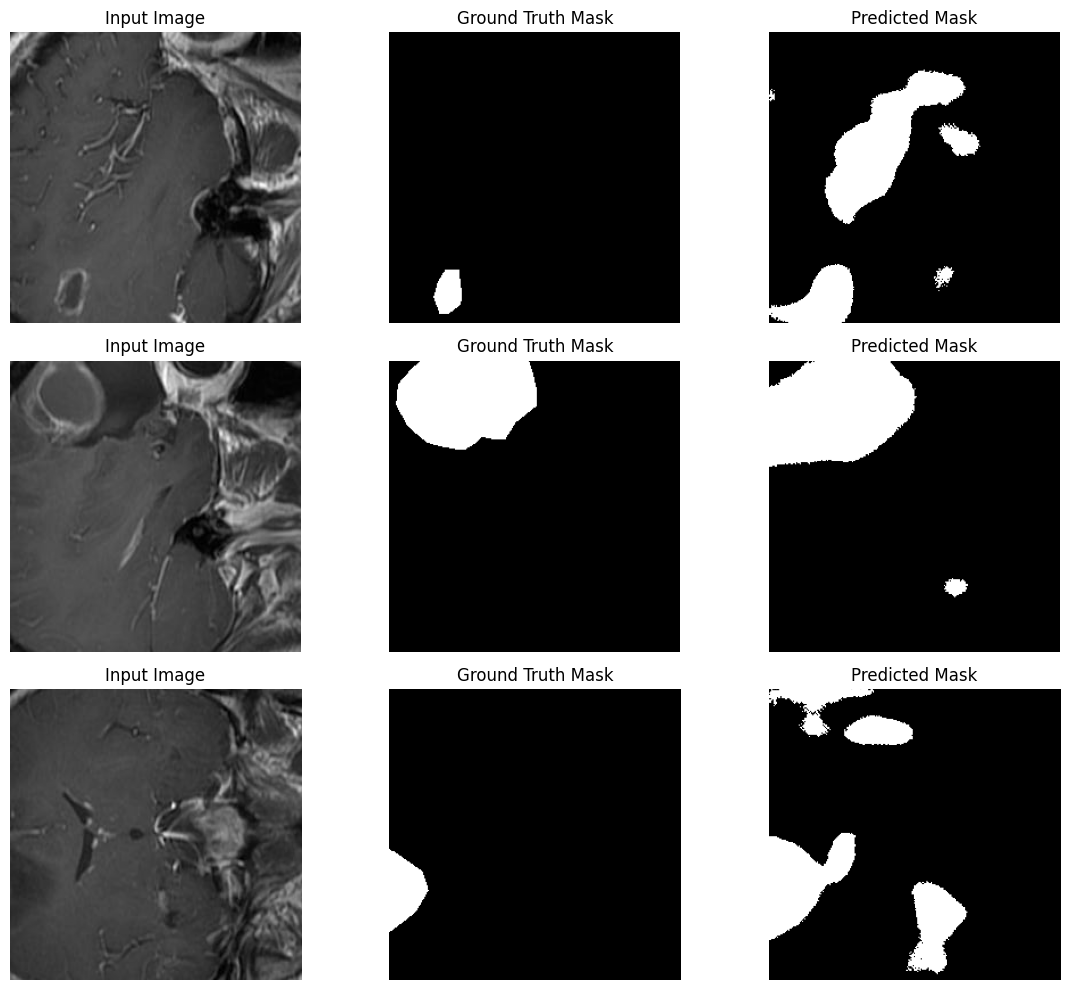

In [10]:
# Full Brain Tumor Segmentation Project with .mat to .jpg Conversion, Real Masks, and Visualization

# Install required packages
# pip install monai scipy matplotlib torch torchvision Pillow tqdm h5py

import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityRanged,
    ToTensord, EnsureTyped, ResizeWithPadOrCropd, AsDiscreted
)
from monai.data import DataLoader, CacheDataset
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.utils import set_determinism
from tqdm import tqdm

# Set seed for reproducibility
set_determinism(seed=0)

# --- Step 1: Convert .mat (v7.3) files using h5py ---
MAT_INPUT_FOLDER = "./brain_tumor_mat/git_brainTumorDataPublic_2299-3064"
OUTPUT_FOLDER = "./brain_tumor_dataset"
LABEL_FOLDER = os.path.join(OUTPUT_FOLDER, "labels")
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
os.makedirs(LABEL_FOLDER, exist_ok=True)

train_files = []
mat_files = [f for f in os.listdir(MAT_INPUT_FOLDER) if f.endswith(".mat")]  # limit to first 100 files

for file in mat_files:
    path = os.path.join(MAT_INPUT_FOLDER, file)
    with h5py.File(path, 'r') as f:
        image = np.array(f['cjdata']['image']).T
        mask = np.array(f['cjdata']['tumorMask']).T
        label = int(np.array(f['cjdata']['label']).squeeze())

    # Normalize image
    im = image.astype(np.float32)
    im = ((im - im.min()) / (im.max() - im.min()) * 255).astype(np.uint8)
    mask = (mask > 0).astype(np.uint8)  # Keep mask as binary 0 or 1

    label_folder = os.path.join(OUTPUT_FOLDER, str(label))
    os.makedirs(label_folder, exist_ok=True)

    base_name = os.path.splitext(file)[0]
    image_path = os.path.join(label_folder, base_name + ".jpg")
    label_path = os.path.join(LABEL_FOLDER, base_name + "_label.png")

    Image.fromarray(im).save(image_path)
    Image.fromarray((mask * 255).astype(np.uint8)).save(label_path)

    train_files.append({"image": image_path, "label": label_path})

# Define transforms
train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=[256, 256]),
    ScaleIntensityRanged(keys=["image"], a_min=0, a_max=255, b_min=0.0, b_max=1.0, clip=True),
    AsDiscreted(keys=["label"], threshold=0.5),
    ToTensord(keys=["image", "label"])
])

# Create dataset (non-caching for speed with larger sets)
from monai.data import Dataset
train_ds = Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=4, num_workers=2, pin_memory=True)

# Define UNet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

# Loss and optimizer
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
max_epochs = 5
model.train()
for epoch in range(max_epochs):
    epoch_loss = 0
    for batch_data in tqdm(train_loader):
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        labels = labels.long()  # Ensure label type is correct
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{max_epochs}, Loss: {epoch_loss:.4f}")

# Save model
torch.save(model.state_dict(), "unet_brain_tumor_segmentation.pth")

# Visualizes 3 random predictions out of the dataset
import random
random.seed()  # Allow fresh randomness each run
model.eval()
with torch.no_grad():
    import random
    samples = random.sample(train_files, 3)
    fig, axes = plt.subplots(3, 3, figsize=(12, 10))
    for i, sample in enumerate(samples):
        data = train_transforms(sample)
        image = data["image"].unsqueeze(0).to(device)
        label = data["label"].unsqueeze(0).to(device)
        output = model(image)
        pred = torch.argmax(output, dim=1)[0].cpu().numpy()
        img_np = image[0][0].cpu().numpy()
        lbl_np = label[0][0].cpu().numpy()

        axes[i][0].imshow(img_np, cmap="gray")
        axes[i][0].set_title("Input Image")
        axes[i][1].imshow(lbl_np, cmap="gray")
        axes[i][1].set_title("Ground Truth Mask")
        axes[i][2].imshow(pred, cmap="gray")
        axes[i][2].set_title("Predicted Mask")
        for a in axes[i]:
            a.axis("off")
    plt.tight_layout()
    plt.show()

